# Fanal, a neutrino-less beta decay experiment 

## An open exercise

##  Sentitivity of the experiment

### USC, Master de Física, Física de Partícula II


J. A. Hernando-Morata, with the help of J. Muñoz, J. M. Benlloch, B. Palmeiro, G. Díaz

February 2021 - February 2022


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants
import scipy.stats     as stats
import scipy.optimize  as optimize

import warnings
warnings.filterwarnings('ignore')

In [3]:
# REMEMBER TO ADD THE FOLDER TO PYTHONPATH
import os
import sys
dirpath = os.getcwd()[:-9]
print('add path to PYTHONPATH : ', dirpath)
sys.path.insert(0, os.path.abspath(dirpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal


In [4]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.efit    as efit     # Fit Utilites - Includes Extend Likelihood Fit with composite PDFs
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
import     collpars as collpars # collaboration specific parameters
pltext.style()

## Indications

### Objective:

**Validate the method to compute the number of signal events**.

### Tasks

   * Open the data file (HDF) and access the simulated data (MC) of 214Bi, 208Tl and bb0nu. 

   * Generate experiments with a given number of signal events and a level of background compatible with the one estimated using the blind-data sample (in previous task).

   * Ensure that the estimation of your signal is correct in different signal scenarios. 
     * Consider for example the case where the signal events are equal to Bi.

   * Try to estimate the uncertainties on the number of signal events.

   * Estimate the half-life for different number signal scenarios.

## Notes

  * To valide a fit, usually we generate a large number of experiments with known true parameters; estimate the parameters, and study their distributions.
  
  * In the case of 'gaussian' limits, these distributions are gaussian, centered in the true value of the parameters and their standard deviations are the uncertentities of the parameters.


### The evil is in the details:

Here we are going to generate n-experiments with the number background events compatible with the values obtained using the blind-data (previous section) and several scenarios of possible number of signal events.

We aply the selection to each experiment data. Here we use the fanal selection, except that we do not apply the last cut, the refined energy region (RoI). Then we fit the energy distribution of the selected data to a combined PDF obtained from the three MC samples (bb0nu, Bi, Tl) in which we have previously applied the selection. 

A trick has been used: as the blob-energy and the event energy are uncorrelated, we have used  the event energy distributions obtained before the blob-energy cut as templates for the PDFs. If we have a large MC statistics we do not need this trick.



## Main parameters

In [5]:
coll          = collpars.collaboration
ntracks_range = collpars.ntracks_range
eblob2_range  = collpars.eblob2_range
erange        = collpars.erange
eroi          = collpars.eroi

print('Collaboration             : {:s}'.format(coll))
print('number of tracks range    : ({:d}, {:6.2f})'.format(*ntracks_range))
print('Blob-2 energy range       : ({:6.3f}, {:6.3f}) MeV'.format(*eblob2_range))
print('Energy range              : ({:6.3f}, {:6.3f}) MeV'.format(*erange))
print('Energy RoI range          : ({:6.3f}, {:6.3f}) MeV'.format(*eroi))

Collaboration             : new_beta
number of tracks range    : (1,   1.10)
Blob-2 energy range       : ( 0.400,  1.200) MeV
Energy range              : ( 2.400,  2.700) MeV
Energy RoI range          : ( 2.430,  2.480) MeV


In [6]:
# list of the selection variables names and ranges
varnames  = ['num_tracks', 'blob2_E', 'E', 'E']
varranges = [ntracks_range, eblob2_range, erange, eroi]
print('varnames  : ', varnames)
print('varranges : ', varranges)

varnames  :  ['num_tracks', 'blob2_E', 'E', 'E']
varranges :  [(1, 1.1), (0.4, 1.2), (2.4, 2.7), (2.43, 2.48)]


In [7]:
# number of  blind events
nevts_Bi_blind = collpars.nevts_Bi_blind
nevts_Tl_blind = collpars.nevts_Tl_blind
nevts_blind    = [nevts_Bi_blind, nevts_Tl_blind]
print('Number of bkg events in blind data : Bi = {:6.2f}, Tl = {:6.2f}.'.format(*nevts_blind))

Number of bkg events in blind data : Bi = 1102.18, Tl = 14619.78.


## Access the data

In [8]:
dirpath = '/Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/'
filename = 'fanal_' + coll + '.h5'
print('Data path and filename : ', dirpath + filename)

mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')

mcs      = [mcbb, mcbi, mctl]
tsamples = ['bb', 'Bi', 'Tl']
ssamples = [r'$\beta\beta0\nu$',r'$^{214}$Bi', r'$^{208}$Tl']

Data path and filename :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/fanal_new_beta.h5


## Generate a MC experiment

### Estimate the number of events

In [53]:
from collpars import nevts_Bi, nevts_Tl, nevts_Bi_E, nevts_Tl_E
from collpars import unevts_Bi, unevts_Tl
from collpars import eff_bb_E

nbb_E = nevts_Bi_E

nevts   = np.array((nbb_E/eff_bb_E, nevts_Bi, nevts_Tl))
print('Total number of events :', *['{:s} \t {:6.1f},'.format(s, ni) for s, ni in zip(tsamples, nevts)])

Total number of events : bb 	   48.7, Bi 	 1403.4, Tl 	 20665.1,


In [54]:
effs_E = np.array((collpars.eff_bb_E, collpars.eff_Bi_E, collpars.eff_Tl_E))
print('efficiencies    ', effs_E)
print('expected events ', effs_E * nevts)
print('events in E', nevts_Bi_E, nevts_Tl_E)

efficiencies     [0.519  0.018  0.0073]
expected events  [ 25.254      25.260894  150.8555147]
events in E 25.254 150.787


### Generate the mc sample pdfs

In [55]:
# define the MC reference samples with only two cuts *ntracks_range*, *erange*
refmcs_vars   = ['num_tracks', 'E']
refmcs_ranges = [ntracks_range, erange]
refmcs        = [ut._select_sample(mc, refmcs_vars, refmcs_ranges) for mc in mcs]

# select the variable and range to generate the pdfs
bins     = 100
varname  = 'E' 
varrange = erange

# generate the PDFs using the blind mc samples
histos   = [np.histogram(mc[varname], bins, range = varrange) for mc    in refmcs]
pdfs     = [stats.rv_histogram(histo)                         for histo in histos]
ell      = efit.ExtComPDF(pdfs)

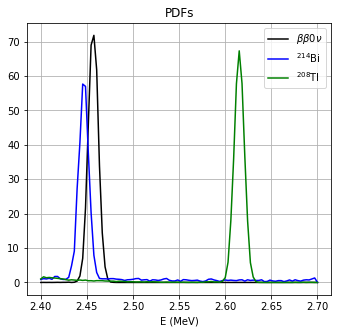

In [56]:
subplot = pltext.canvas(1); subplot(1);
xs       = np.linspace(*varrange, bins)
for i, pdf in enumerate(pdfs): 
    plt.plot(xs, pdf.pdf(xs), label = ssamples[i])
plt.grid(); plt.legend(); 
plt.xlabel('E (MeV)'); plt.title('PDFs');

### Generate  a MC experiment and Fit the E spectrum

In [62]:

nbb_E = nevts_Bi_E
nevts   = np.array((nbb_E/eff_bb_E, nevts_Bi, nevts_Tl))
unevts  = (False, collpars.unevts_Bi, collpars.unevts_Tl)

print('Total number of events :', *['{:s} \t {:6.1f},'.format(s, ni) for s, ni in zip(tsamples, nevts)])
print('Unc   number of events :', *['{:s} \t {:6.1f},'.format(s, ni) for s, ni in zip(tsamples, unevts)])

Total number of events : bb 	   48.7, Bi 	 1403.4, Tl 	 20665.1,
Unc   number of events : bb 	    0.0, Bi 	   63.2, Tl 	  176.2,


In [63]:
# generate an experiment from mc samples
mcdat     = fn.generate_mc_experiment(mcs, nevts)
print('data size ', len(mcdat))

# apply selection
print('selection        :', varnames[:-1])
print('selection ranges :', varranges[:-1])
mcdatana  = ut._select_sample(mcdat, varnames[:-1], varranges[:-1])
print('selected data size ', len(mcdatana))

# data selection efficiency
eff_data  = float(len(mcdatana)/len(mcdat))

print('data selection efficiency {:1.2e}'.format(eff_data))

data size  21931
selection        : ['num_tracks', 'blob2_E', 'E']
selection ranges : [(1, 1.1), (0.4, 1.2), (2.4, 2.7)]
selected data size  180
data selection efficiency 8.21e-03


In [65]:
# array with the energies of selected mc-data in erange
enes      = mcdatana[varname].values 

# expecte number of events in the selected mc-data
nevts_exp = nevts  * effs_E 

res       = ell.best_estimate(enes, *nevts_exp)
nevts_est = res.x
print(nevts_est)

print('Total number of events     :', *['{:s} = {:6.2f}, '.format(si, ni) \
                                              for si, ni in zip(tsamples, nevts)])
print('Expected number of events  :', *['{:s} = {:6.2f}, '.format(si, ni) \
                                              for si, ni in zip(tsamples, nevts_exp)])

print('Fit success ?              :', res.success)
print('Estimated number of events :', *['{:s} = {:6.2f}, '.format(si, ni) \
                                              for si, ni in zip(tsamples, nevts_est)])

[ 13.08233184  22.51837246 144.39563067]
Total number of events     : bb =  48.66,  Bi = 1403.38,  Tl = 20665.14, 
Expected number of events  : bb =  25.25,  Bi =  25.26,  Tl = 150.86, 
Fit success ?              : True
Estimated number of events : bb =  13.08,  Bi =  22.52,  Tl = 144.40, 


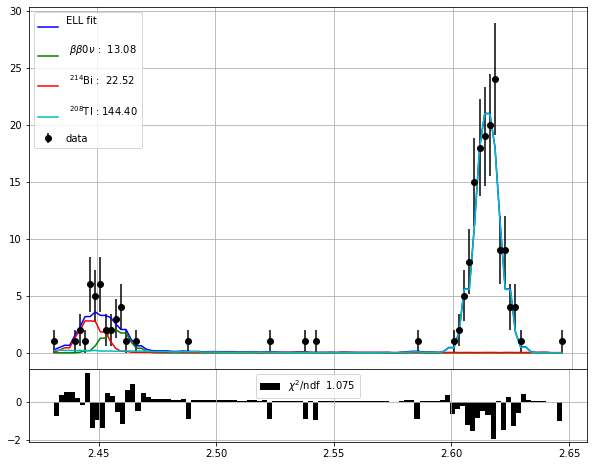

In [66]:
# Plot the distribution of the energies of the blind data
# over impose the pdfs with scaled by the estimated number of blind events in each sample
fn.plot_fit_ell(enes, nevts_est, ell, parnames = ssamples)

data size  22281
selection variables  : ['E', 'num_tracks', 'blob2_E']
selection ranges     : [(2.4, 2.65), (1.0, 1.1), (0.4, inf)]
selection mc samples : ['E', 'num_tracks']
data size            : 189
mc sizes             : [30217, 6688, 31607]
efficiencies         :   0.52, 1.76e-02, 7.28e-03
Initial       Events :  25.26,  24.65, 150.43
Uncertainties Events :   0.00,   1.11,   1.28
Fit success          :  True
Estimated     Events :  29.62,  24.52, 150.29
Expected      [ 25.2539142   25.25361872 150.78731914]
Unc Expected  [0.         1.13770424 1.28570772]
Estimated     [ 29.62420949  24.51907328 150.2855695 ]


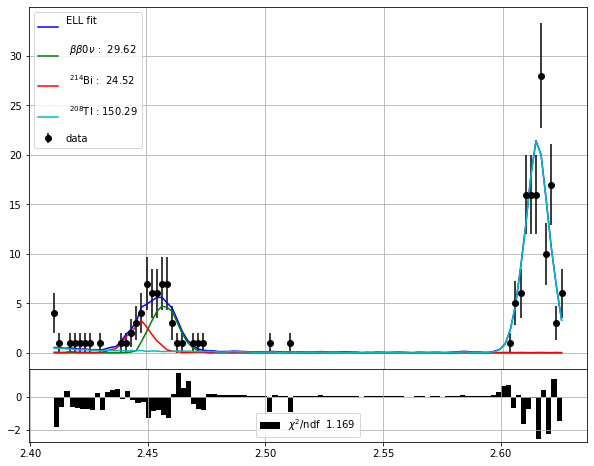

In [105]:
nbb_E = nevts_Bi_E
nevts   = np.array((nbb_E/eff_bb_E, nevts_Bi, nevts_Tl))
unevts  = (False, collpars.unevts_Bi, collpars.unevts_Tl)

# generate an experiment from mc samples
mcdat     = fn.generate_mc_experiment(mcs, nevts)
print('data size ', len(mcdat))

ns_exp, uns_exp = fn._nevents_expected_in_selection(nevts, mcs, varnames[:-1], varranges[:-1], unevts)
res, ene, ell   = fn.ana_experiment(mcdat, mcs, nevts, unevts)
ns_est = res.x 
print('Expected     ', ns_exp)
print('Unc Expected ', uns_exp)
print('Estimated    ', ns_est)

### Fit the Energy distribution

## Fit to the 3 samples: estimate the number of signal events


 The *ana_experiment* in the *fanal* module does the analysis:
 
  1. Selects the data and the MC-samples. It uses fanal selection (E-range, 1-track, blob2 > 0.4 MeV).
  
  2. Creates the Composide PDF with the MC-selected samples for the energy.
  
  3. Fits the energy of selected data to the composite PDF.
  
  4. Returns the fit results, the energy values, the ExtComPDF object, and the efficiencies of the selection in MC 



selection variables  : ['E', 'num_tracks', 'blob2_E']
selection ranges     : [(2.4, 2.65), (1.0, 1.1), (0.4, inf)]
selection mc samples : ['E', 'num_tracks']
data size            : 199
mc sizes             : [30217, 6688, 31607]
efficiencies         :   0.52, 1.76e-02, 7.28e-03
Initial       Events :  25.26,  24.65, 150.43
Fit success          :  True
Estimated     Events :  24.08,  17.95, 156.97
(array([ 25.2539142 ,  25.25361872, 150.78731914]), None)
[ 24.08306707  17.94765917 156.96731028]


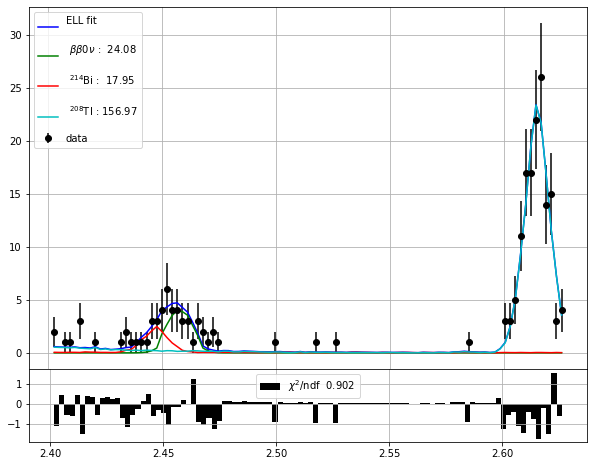

In [106]:
#  do the analysis
mcdat  = fn.generate_mc_experiment(mcs, nevts)
ns_exp = fn._nevents_expected_in_selection(nevts, mcs, varnames[:-1], varranges[:-1])
res, ene, ell = fn.ana_experiment(mcdat, mcs, nevts)
ns_est = res.x 
print(ns_exp)
print(ns_est)

### Generate n-experiments in different signal scenarios.

Generate n-experiments (1000) with different 0bbnu events, for example 100, 10, 2 events in the RoI. 

Be careful with the case of very few bb0nu events in the RoI.

Get the distribution of the estimated number of events. 

Estimate the number of events uncertainties for each scenario

In [107]:
### Compute the efficiencies in the E-range of the fit for Bi, Tl

In [129]:
def tmu(ell, enes, mu, mubest):
    return -2 * (ell.loglike(enes, *mu) - ell.loglike(enes, *mubest))

def tmu1(ell, enes, mu, mubest):
    mask = (False, True, True)
    mu1 = np.copy(mubest)
    mu1[0] = mu[0]
    res = ell.best_estimate(enes, *mu1, mask = mask)
    #print(mu1, res.x)
    result = tmu(ell, enes, res.x, mubest) if res.success else 0
    return result                            

def q0(ell, enes, mubest):
    
    mask = (False, True, True)
    mu = np.copy(mubest)
    mu[0] = 0
    res = ell.best_estimate(enes, *mu, mask = mask)
    result = tmu(ell, enes, res.x, mubest) if res.success else 0
    return np.sqrt(result)

def experiments(mcs, size, nevts, unevts = None, ssamples = ssamples, plot = True):
    
    nevts0 = fn._nevents_expected_in_selection(nevts, mcs, varnames[:-1], varranges[:-1], unevts)
    print('nevts0', nevts0)

    nevts0 = nevts0[0] if unevts != None else nevts0
    print('nevts0', nevts0)
    
    mevts  = []
    for i in range(size):
        mdat            = fn.generate_mc_experiment(mcs, nevts, unevts)
        res, enes, ell  = fn.ana_experiment(mdat, mcs, nevts, unevts = unevts, verbose = False)
        if (res.success): 
            tmui  = tmu (ell, enes, nevts0, res.x)
            tmu1i = tmu1(ell, enes, nevts0, res.x)
            q0i   = q0  (ell, enes, res.x)
            mevts.append((*res.x, tmui, tmu1i, q0i))
            
    def _plot():
        tnames = ('tmu', 'tmu1', 'q0')
        subplot = pltext.canvas(6)
        for i in range(len(mevts[0])):
            subplot(i + 1)
            nn = [m[i] for m in mevts]
            _, bins, _ = pltext.hist(nn, 100, density = True);
            if (i < 3): plt.xlabel('n events');
            title = ssamples[i] if i < 3 else tnames[i-3]            
            plt.title(title)
            xs = 0.5*(bins[1:] + bins[:-1])
            if (i == 3):
                ndf = 3 # if nevts0[0] > 0 else 3
                plt.plot(xs, stats.chi2.pdf(xs, ndf));
            if (i == 4):
                fac = 1 if nevts0[0] > 0 else 0.5
                plt.plot(xs, fac * stats.chi2.pdf(xs, 1));
                plt.yscale('log')
        plt.tight_layout()

    if (plot): _plot()
    return mevts  

Total events           : 486.5895953757226 1403.383 20665.139
Expected events        : 252.53914196141554 25.253618719260935 150.78731914296148
Unc Exp events         : 0.0 1.1377042403296558 1.285707721698189
Expected Events in fit : 252.54000000000002 25.260894 150.8555147
nevts0 (array([252.53914196,  25.25361872, 150.78731914]), array([0.        , 1.13770424, 1.28570772]))
nevts0 [252.53914196  25.25361872 150.78731914]


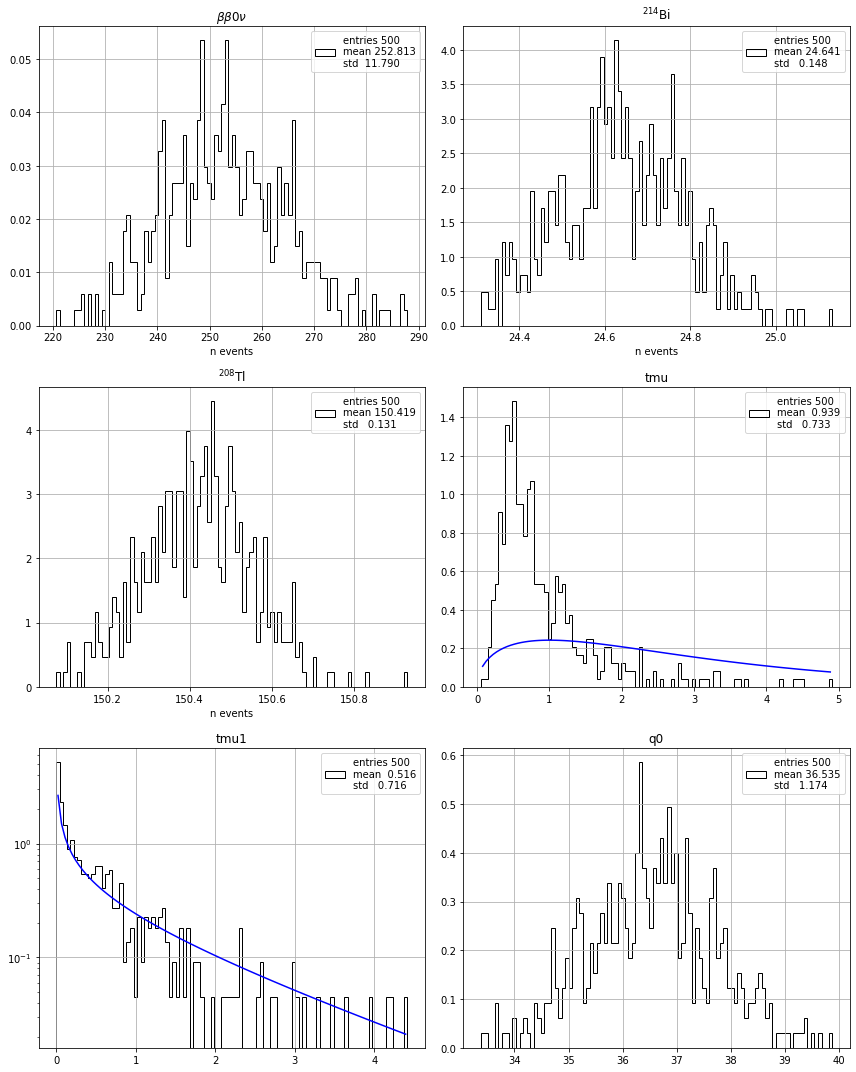

In [135]:
size    = 500
nbb_E   = 10. * nevts_Bi_E
nevts_fit = (nbb_E, nevts_Bi * collpars.eff_Bi_E, nevts_Tl * collpars.eff_Tl_E)
nevts     = (nbb_E/eff_bb_E, nevts_Bi, nevts_Tl)
unevts    = (False, collpars.unevts_Bi, collpars.unevts_Tl)

mevts, umevts = fn._nevents_expected_in_selection(nevts, mcs, varnames[:-1], varranges[:-1], unevts)

print('Total events           :', *nevts)
print('Expected events        :', *mevts)
print('Unc Exp events         :', *umevts)
print('Expected Events in fit :', *nevts_fit)
evts   = experiments(mcs, size, nevts, unevts)

Total events           : 48.65895953757226 1403.383 20665.139
Expected Events in fit : 25.254 25.260894 150.8555147


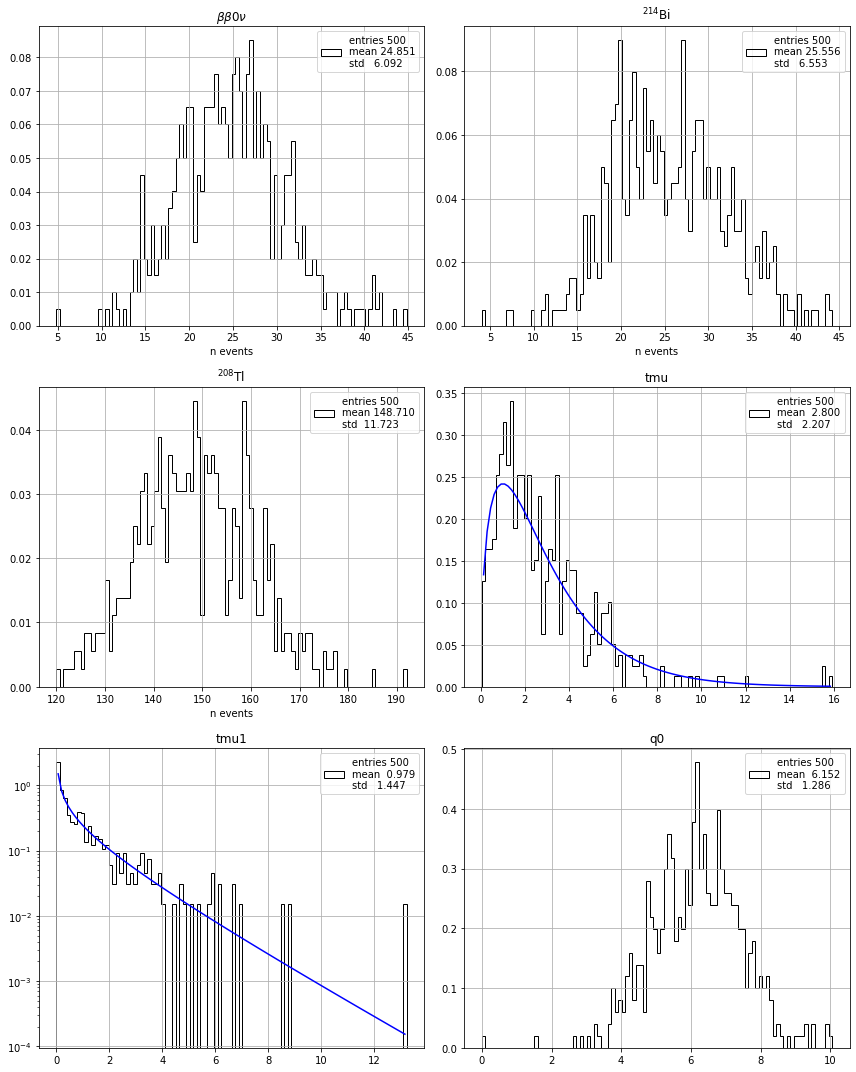

In [37]:
size    = 500
nbb_E   = 1. * nevts_Bi_E
nevts_fit = (nbb_E, nevts_Bi * collpars.eff_Bi_E, nevts_Tl * collpars.eff_Tl_E)
nevts     = (nbb_E/eff_bb_E, nevts_Bi, nevts_Tl)
print('Total events           :', *nevts)
print('Expected Events in fit :', *nevts_fit)
mevts   = experiments(mcs, size, nevts)

Total events           : 24.32947976878613 1403.383 20665.139
Expected Events in fit : 12.627 25.260894 150.8555147


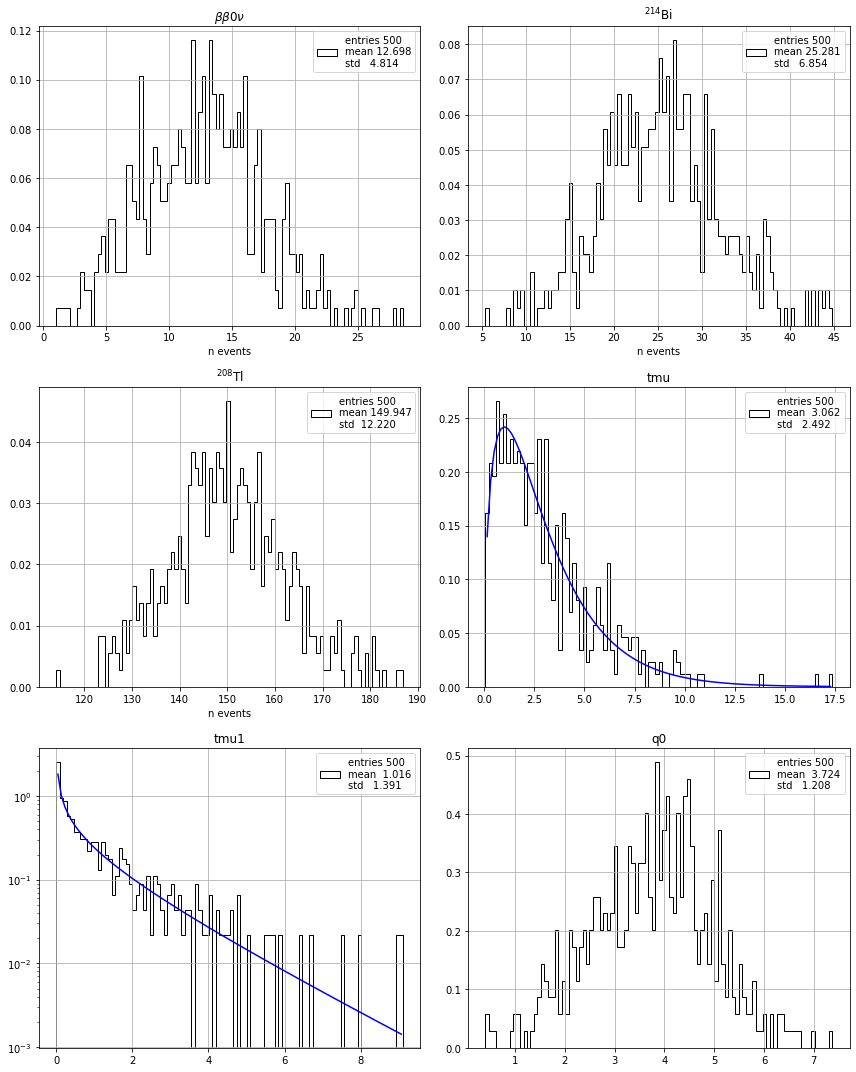

In [38]:
size    = 500
nbb_E   = 0.5 * nevts_Bi_E
nevts_fit = (nbb_E, nevts_Bi * collpars.eff_Bi_E, nevts_Tl * collpars.eff_Tl_E)
nevts     = (nbb_E/eff_bb_E, nevts_Bi, nevts_Tl)
print('Total events           :', *nevts)
print('Expected Events in fit :', *nevts_fit)
mevts   = experiments(mcs, size, nevts)

Total events           : 0.0 1403.383 20665.139
Expected Events in fit : 0.0 25.260894 150.8555147


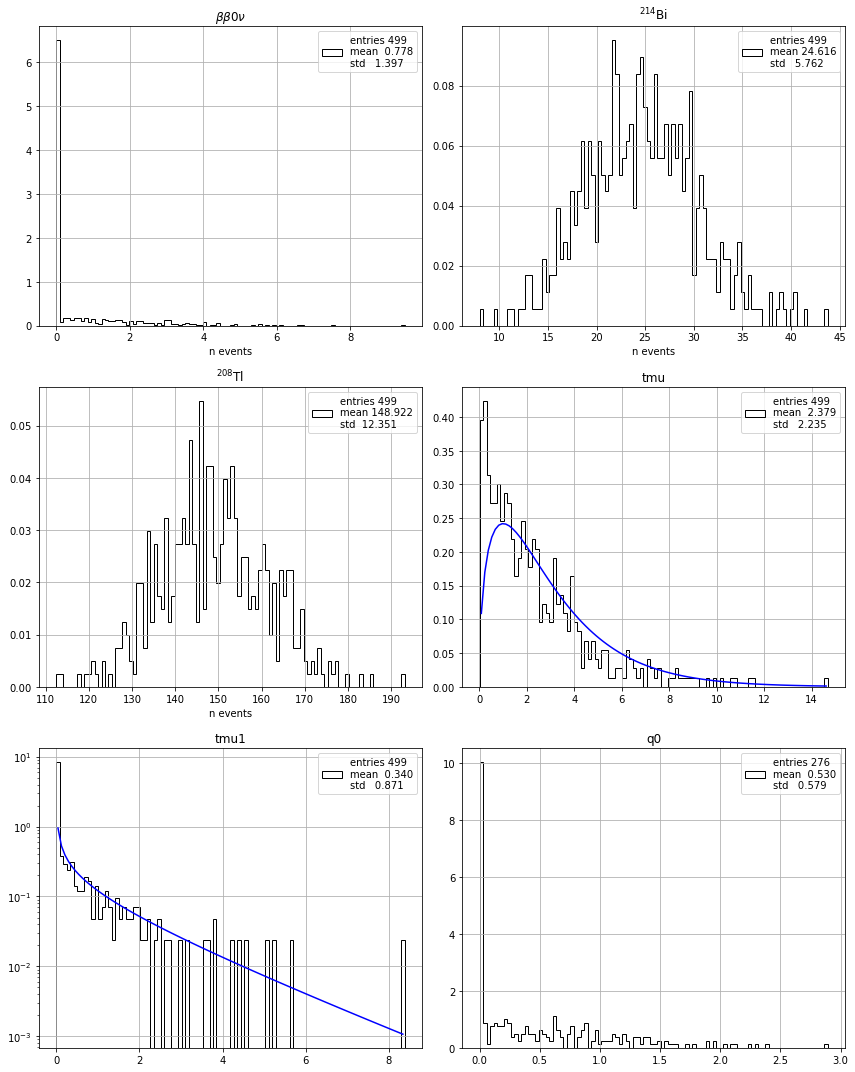

In [39]:
size    = 500
nbb_E   = 0. * nevts_Bi_E
nevts_fit = (nbb_E, nevts_Bi * collpars.eff_Bi_E, nevts_Tl * collpars.eff_Tl_E)
nevts     = (nbb_E/eff_bb_E, nevts_Bi, nevts_Tl)
print('Total events           :', *nevts)
print('Expected Events in fit :', *nevts_fit)
mevts   = experiments(mcs, size, nevts)

## Estimate the half-time

In [52]:
from collpars import exposure

nevts_bb_RoI = nevts_Bi_RoI
acc_bb       = 0.794
eff          = acc_bb * eff_bb_RoI
tau          = fn.half_life(nevts_bb_RoI, exposure, eff)

print('number of bb0nu events  : {:6.3f}'.format(nevts_bb_RoI))
print('exposure                : {:6.2f} kg y'.format(exposure))
print('total signal efficiency : {:6.3f}'.format(eff))
print('bb0nu half-life         : {:6.2e} y '.format(tau))

number of bb0nu events  : 65.991
exposure                : 3000.00 kg y
total signal efficiency :  0.411
bb0nu half-life         : 5.17e+25 y 
